# Example notebook for transforming 3D STL files into layered GDS files 

In [1]:
###Transform a STL into a GDS 

import numpy as np
import matplotlib.pyplot as plt 
import trimesh
from shapely.geometry import LineString
from shapely.geometry import Polygon

import gdshelpers
from gdshelpers.geometry.chip import Cell


%matplotlib notebook
%config InlineBackend.print_figure_kwargs={'bbox_inches':None}



######NUMBER OF GSLEVELS = n 
n=20

In [2]:
# load the mesh from filename
mesh= trimesh.load_mesh('INL_TEST.stl') #this one has a better mesh
mesh

<trimesh.Trimesh(vertices.shape=(1267, 3), faces.shape=(2442, 3))>

In [3]:
#show the imported mesh 
import networkx
mesh.show()

<IPython.core.display.Javascript object>


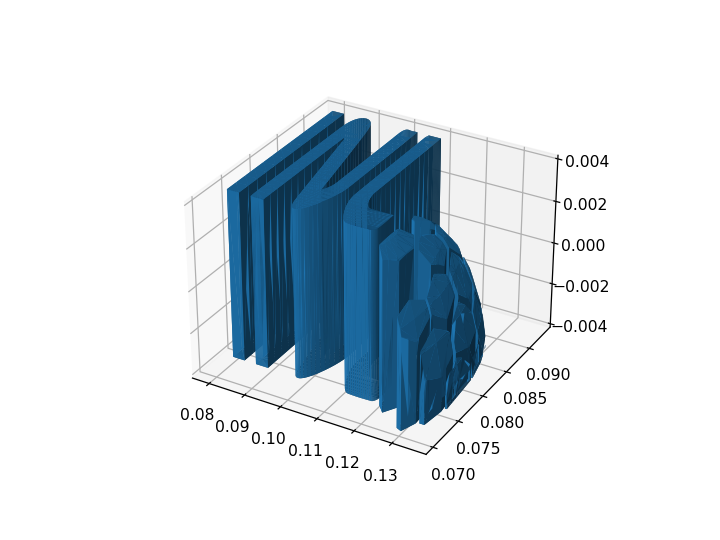

In [4]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_trisurf(mesh.vertices[:, 0], mesh.vertices[:,1], triangles=mesh.faces, Z=mesh.vertices[:,2]) 
plt.show()

In [5]:
#Get maximum and minimum from the stl files
hmax = np.max(mesh.vertices[:,2].ravel())
hmin = np.min(mesh.vertices[:,2].ravel())
#print(hmax) #in mm
#print(hmin)

dz = (hmax-hmin)/n

#INTERCEPTION Z LEVELS ARRAY
zlevels = np.arange(hmin,hmax+dz,dz) #in m
zlevels

array([-4.00000066e-03, -3.60000061e-03, -3.20000057e-03, -2.80000053e-03,
       -2.40000049e-03, -2.00000044e-03, -1.60000040e-03, -1.20000036e-03,
       -8.00000317e-04, -4.00000275e-04, -2.32830645e-10,  3.99999809e-04,
        7.99999852e-04,  1.19999989e-03,  1.59999994e-03,  1.99999998e-03,
        2.40000002e-03,  2.80000006e-03,  3.20000011e-03,  3.60000015e-03,
        4.00000019e-03])

In [6]:
#here we work with the mesh only with z discretization
sections = mesh.section_multiplane(plane_origin=mesh.bounds[0], 
                                      #plane_normal=[0,0,-1], #the plane normal is also directional -> slices go up or down
                                      plane_normal=[0,0,1], #the plane normal is also directional -> slices go up or down
                                      heights=np.array(zlevels-hmin+0.0001-dz))

sections = list(filter(None, sections)) 

sections

[<trimesh.Path2D(vertices.shape=(1174, 2), len(entities)=23)>,
 <trimesh.Path2D(vertices.shape=(1156, 2), len(entities)=22)>,
 <trimesh.Path2D(vertices.shape=(1110, 2), len(entities)=22)>,
 <trimesh.Path2D(vertices.shape=(1080, 2), len(entities)=18)>,
 <trimesh.Path2D(vertices.shape=(1062, 2), len(entities)=18)>,
 <trimesh.Path2D(vertices.shape=(1038, 2), len(entities)=16)>,
 <trimesh.Path2D(vertices.shape=(1034, 2), len(entities)=16)>,
 <trimesh.Path2D(vertices.shape=(1014, 2), len(entities)=14)>,
 <trimesh.Path2D(vertices.shape=(1005, 2), len(entities)=14)>,
 <trimesh.Path2D(vertices.shape=(1005, 2), len(entities)=14)>,
 <trimesh.Path2D(vertices.shape=(980, 2), len(entities)=11)>,
 <trimesh.Path2D(vertices.shape=(970, 2), len(entities)=11)>,
 <trimesh.Path2D(vertices.shape=(956, 2), len(entities)=11)>,
 <trimesh.Path2D(vertices.shape=(936, 2), len(entities)=10)>,
 <trimesh.Path2D(vertices.shape=(911, 2), len(entities)=7)>,
 <trimesh.Path2D(vertices.shape=(907, 2), len(entities)=7)>,


In [7]:
#Create cell with polygons from the intersection of planes with the STL 3D geometry 
cell = Cell('TOP')

#create the initial one
polygon1 = sections[0].polygons_full[0]
cell.add_to_layer(0, polygon1)

layerspol = np.arange(0,np.size(sections))

#here we go until the end, but from half, the diff gives empty
for i in layerspol: 
    print(i)

    for poli in sections[i].polygons_full:
        polygon1 = poli
        cell.add_to_layer(i, polygon1)
        cell.get_reduced_layer(i)
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [8]:
#EXPORT CELL TO .GDS 
file = open('INL_logo'+str(int(n))+'.gds','wb')
                                                  
gdshelpers.export.gdsii_export.write_cell_to_gdsii_file(file, cell, \
                                                        unit=1e-3, grid_steps_per_unit=1000000, max_points=40000,\
                                                        max_line_points=40000, timestamp=None, parallel=False, \
                                                        max_workers=None)

file.close()

In [9]:
#Correct for layers overlapping in area 
import pya

readfile = 'INL_logo'+str(int(n))+'.gds'
outputfile = 'INL_logo'+str(int(n))+'_diffs.gds'
cellname = 'TOP'

#define layout and read layout from file
layoutor = pya.Layout()
lmap = layoutor.read(readfile)
cell = layoutor.cell(cellname)

thr = 1

#for all the layers in layerspol array 
for lyrs in layerspol:
    print(lyrs)
    np1 = int(lyrs)
    layer1 = layoutor.layer(np1,np1)

    #region with all the shapes 
    region1 = pya.Region(cell.shapes(layer1))
    np2= int(lyrs+1)
    layer2 = layoutor.layer(np2,np2)
    region2 = pya.Region(cell.shapes(layer2))
   
    #make the difference of the layer2 on layer1
    result = region1-region2 
    result = result.with_area(0,10000,1)
   
    #temp save of the result layer (to be cleared)
    resultlay = layer1
    cell.layout().clear_layer(layer1) #clear the results layer
    
    #insert shapes from boolean into the resultslayer 
    cell.shapes(resultlay).insert(result)
    
layoutor.write(outputfile)
    
print("Sequentially made the difference between layers "+str(layerspol)+" in the file "+str(readfile))
print("Saved the result to "+str(outputfile))



0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
Sequentially made the difference between layers [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19] in the file INL_logo20.gds
Saved the result to INL_logo20_diffs.gds
